In [1]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import sys
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])
train_dataset = MNIST('/data', train=True, download=True, transform=transform)
test_dataset = MNIST('/data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=True)

In [3]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

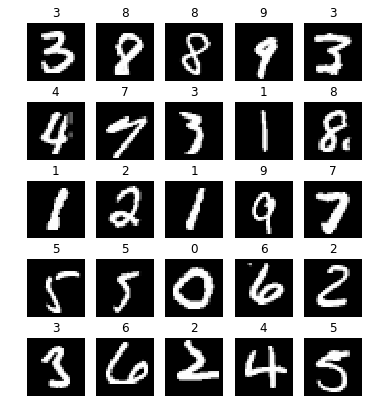

In [4]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

In [5]:
class LeNet_plus(nn.Module):
    def __init__(self):
        super(LeNet_plus, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, stride=1, padding=2)
        self.act1 = nn.PReLU()
        self.conv2 = nn.Conv2d(32, 32, 5, stride=1, padding=2)
        self.act2 = nn.PReLU()
        self.pool1 = nn.MaxPool2d(2, stride=2, padding=0)

        self.conv3 = nn.Conv2d(32, 64, 5, stride=1, padding=2)
        self.act3 = nn.PReLU()
        self.conv4 = nn.Conv2d(64, 64, 5, stride=1, padding=2)
        self.act4 = nn.PReLU()
        self.pool2 = nn.MaxPool2d(2, stride=2, padding=0)

        self.conv5 = nn.Conv2d(64, 128, 5, stride=1, padding=2)
        self.act5 = nn.PReLU()
        self.conv6 = nn.Conv2d(128, 128, 5, stride=1, padding=2)
        self.act6 = nn.PReLU()
        self.pool3 = nn.MaxPool2d(2, stride=2, padding=0)
            
        self.fc1 = nn.Linear(3*3*128, 2)
        self.act7 = nn.PReLU()
        self.fc2 = nn.Linear(2, 10)
    
    def forward(self, x):
        x = self.act1(self.conv1(x))
        x = self.act2(self.conv2(x))
        x = self.pool1(x)
        
        x = self.act3(self.conv3(x))
        x = self.act4(self.conv4(x))
        x = self.pool2(x)
        
        x = self.act5(self.conv5(x))
        x = self.act6(self.conv6(x))
        x = self.pool3(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.act7(self.fc1(x))
        x = F.log_softmax(self.fc2(x))
        
        return x

In [6]:
def train(network, optimizer, epochs):
    global test_marks, train_marks
    
    loss = nn.NLLLoss()
    
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []

    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            batch_marks = []

            network.train()
            for batch_idx, (X, y) in enumerate(train_loader):
                batch_marks.extend(y.numpy())
                X, y = X.to(device), y.to(device)
                network.zero_grad()
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.data[0])
                loss_batch.backward()
                optimizer.step()
                accuracies.append((np.argmax(prediction.cpu().data.numpy(), 1)==y.cpu().data.numpy()).mean())
                
                if batch_idx % 10 == 0:
                    sys.stdout.write('\rTrain Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        epoch, batch_idx * len(X), len(train_loader.dataset),
                        100. * batch_idx / len(train_loader), losses[-1]))
            
            train_marks.append(batch_marks)
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            
            losses = []
            accuracies = []
            batch_marks = []

            network.eval()
            for X, y in test_loader:
                batch_marks.extend(y.numpy())
                X, y = X.to(device), y.to(device)
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.data[0])
                accuracies.append((np.argmax(prediction.cpu().data.numpy(), 1)==y.cpu().data.numpy()).mean())
                
            test_marks.append(batch_marks)
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            print('\nEpoch {0}. (Train/Test) Average loss: {1:.4f}/{2:.4f}\tAccuracy: {3:.4f}/{4:.4f}\n'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
    
    except KeyboardInterrupt:
        pass
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_epochs, label='Train')
    plt.plot(test_loss_epochs, label='Test')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy_epochs, label='Train accuracy')
    plt.plot(test_accuracy_epochs, label='Test accuracy')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.ylim(0.9, 1.0)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.show()

In [7]:
def get_out(self, input, output):
    global conv_out
    conv_out = np.concatenate((conv_out, output.cpu().data.numpy()), axis=0)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

network = LeNet_plus().to(device)
optimizer = optim.Adam(network.parameters(), lr=1e-4)

network.fc1.register_forward_hook(get_out)

In [9]:
conv_out = np.empty([0,2])
test_marks = []
train_marks = []

Train Epoch: 0 [59520/60000 (99%)]	Loss: 0.681096
Epoch 0. (Train/Test) Average loss: 1.1091/0.5861	Accuracy: 0.5937/0.8579

Train Epoch: 1 [59520/60000 (99%)]	Loss: 0.199655
Epoch 1. (Train/Test) Average loss: 0.4504/0.3591	Accuracy: 0.8921/0.9195

Train Epoch: 2 [59520/60000 (99%)]	Loss: 0.139027
Epoch 2. (Train/Test) Average loss: 0.3125/0.2624	Accuracy: 0.9406/0.9494

Train Epoch: 3 [59520/60000 (99%)]	Loss: 0.488066
Epoch 3. (Train/Test) Average loss: 0.2339/0.1946	Accuracy: 0.9543/0.9592

Train Epoch: 4 [59520/60000 (99%)]	Loss: 0.156609
Epoch 4. (Train/Test) Average loss: 0.1789/0.1880	Accuracy: 0.9606/0.9609

Train Epoch: 5 [59520/60000 (99%)]	Loss: 0.137488
Epoch 5. (Train/Test) Average loss: 0.1434/0.1781	Accuracy: 0.9661/0.9667

Train Epoch: 6 [59520/60000 (99%)]	Loss: 0.172124
Epoch 6. (Train/Test) Average loss: 0.1177/0.1454	Accuracy: 0.9727/0.9706

Train Epoch: 7 [59520/60000 (99%)]	Loss: 0.045030
Epoch 7. (Train/Test) Average loss: 0.1029/0.1334	Accuracy: 0.9768/0.9750



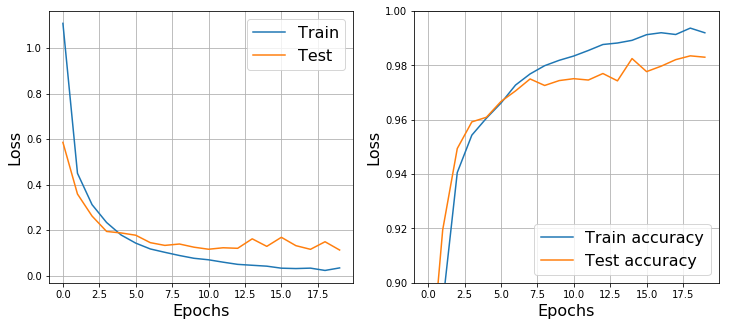

In [10]:
train(network, optimizer, 20)

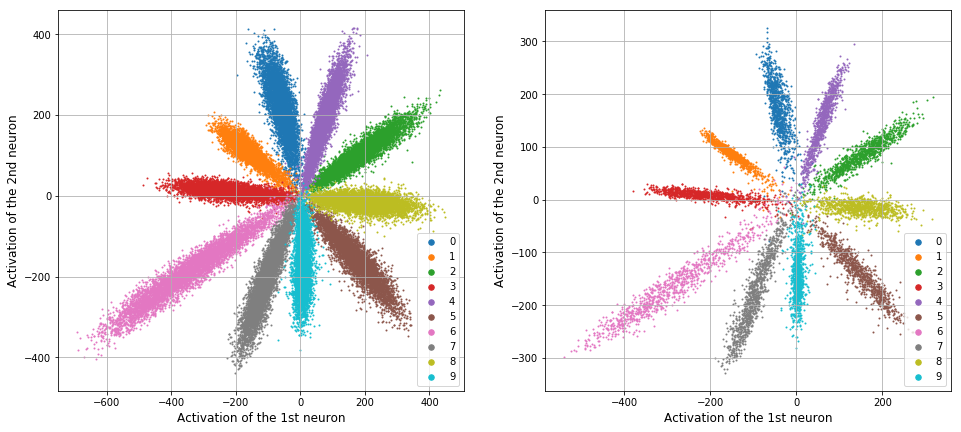

In [11]:
last_conv_out = conv_out[-70000:]
plt.figure(figsize=(16, 7))

colors = ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']
plt.subplot(1, 2, 1)
for label in range(10):
    plt.scatter(last_conv_out[:60000, 0][np.array(train_marks[-1])==label],
                last_conv_out[:60000, 1][np.array(train_marks[-1])==label], 
                s=1, c=colors[label])

lgnd = plt.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], loc="lower right")
for idx in range(10):
    lgnd.legendHandles[idx]._sizes = [30]
plt.xlabel('Activation of the 1st neuron', fontsize=12)
plt.ylabel('Activation of the 2nd neuron', fontsize=12)
plt.grid('on')

plt.subplot(1, 2, 2)
for label in range(10):
    plt.scatter(last_conv_out[-10000:, 0][np.array(test_marks[-1])==label],
                last_conv_out[-10000:, 1][np.array(test_marks[-1])==label], 
                s=1, c=colors[label])
    
lgnd = plt.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], loc="lower right")
for idx in range(10):
    lgnd.legendHandles[idx]._sizes = [30]    
plt.xlabel('Activation of the 1st neuron', fontsize=12)
plt.ylabel('Activation of the 2nd neuron', fontsize=12)
plt.grid('on')
plt.show()